In [2]:
import os
import re


# Patch for deprecated np.float usage in legacy code
import numpy as np
if not hasattr(np, 'float'):
    np.float = float
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

sm.OLS.from_formula

from pmdarima import auto_arima

from pylab import rcParams

In [5]:
#filtro por fecha
def filter_company_data(company_df, start_date, end_date):
    return company_df[(company_df['Date'] >= start_date) & (company_df['Date'] <= end_date)]

# Funcion para convertir signo dolar a numerico
def convert_dollars_to_numerical(value):
    if isinstance(value, str) and re.match(r'\$\d+', value):
        return float(value.replace('$', ''))
    return value

# funcion para calcular el RMSE
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

# función para predicción random walk
def random_walk_pred (df, target_column, test_size):
        
    data = df.copy()
    
    #separa en train y test
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)
    
    #genero desplazo en train
    data_train["PriceShift1"] = data_train[target_column].shift()
    data_train["PriceShift1"].fillna(method='bfill', inplace=True)
    
    #genero desplazo en test
    data_test["PriceShift1"] = data_test[target_column].shift()
    data_test["PriceShift1"].fillna(method='bfill', inplace=True)
    
    data_train["RandomWalk"] = data_train.PriceShift1    
    data_test["RandomWalk"] = pd.Series(data_train[target_column].iloc[-1], index=data_test.index)
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"RandomWalk"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Random Walk Prediction')
    plt.show()
    
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "Random Walk"
    df_Results.loc[index, "RMSE"] = RMSE(data_test.RandomWalk, data_test[target_column])
    df_Results
    
    print(df_Results.head())
    
    return

# defino funcion predictiva con la media
def mean_pred(df, target_column, test_size):
    
    data = df.copy()
    
    #separa en train y test
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)

    model_mean_pred = data_train[target_column].mean()
    print('Mean: ', model_mean_pred)
    
    #df_train_mc = data train.copy()
    data_train['Mean'] = model_mean_pred
    
    #df_test_mc = data_train.copy()
    data_test['Mean'] = model_mean_pred
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"Mean"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Mean Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.Mean, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "Mean"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    
    return

# defino una funcion para predecir con la tendencia lineal
def lineal_pred(df, target_column,test_size):
    
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)
    data.timeIndex.head(3)
    
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)
    
    formula = f'{target_column} ~ timeIndex'
    model_linear = smf.ols(formula=formula, data = data_train).fit()
    
    data_train["LinearTrend"] = model_linear.predict(data_train.timeIndex)
    data_test["LinearTrend"] = model_linear.predict(data_test.timeIndex)
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"LinearTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Lineal Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.LinearTrend, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "LinearTrend"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_linear.summary())
    
    return

#defino una funcion para predecicción exponencial
def exp_pred(df, target_column, test_size, exp=2):
   
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)
    data["timeIndex_exp"] = data["timeIndex"]**exp
    data.timeIndex_exp.head(3)
    
    data_train, data_test = train_test_split(data, test_size = test_size, random_state=2024, shuffle=False)
    
    formula = f'{target_column} ~ timeIndex + timeIndex_exp'
    model_exp = smf.ols(formula = formula, data = data_train).fit()

    data_train["ExpTrend"] = model_exp.predict(data_train[["timeIndex","timeIndex_exp"]])
    data_test["ExpTrend"] = model_exp.predict(data_test[["timeIndex","timeIndex_exp"]])
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"ExpTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Exponencial Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.ExpTrend, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "ExpTrend"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_exp.summary())
    
    return

# defino una función para hacer predección logaritmica
def log_pred(df, target_column, test_size):
    
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)

    data_train, data_test = train_test_split(data, test_size = test_size, random_state=2024, shuffle=False)
    
    data_train['log_target'] = np.log(data_train[target_column])
    data_test['log_target'] = np.log(data_test[target_column])
    
    model_log = smf.ols('log_target ~ timeIndex ', data = data_train).fit()
    
    data_train["LogTrend"] = model_log.predict(data_train[["timeIndex"]])
    data_test["LogTrend"] = model_log.predict(data_test[["timeIndex"]])
    
    data_train['back_LogTrend'] = np.exp(data_train['LogTrend'])
    data_test['back_LogTrend'] = np.exp(data_test['LogTrend'])
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"back_LogTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test - Logaritmical Prediction')
    plt.show()
    
    model_RMSE = RMSE(data_test.back_LogTrend, data_test[target_column])
    index = df_Results.shape[0]
    df_Results.loc[index, "Model"] = "back_LogTrend"
    df_Results.loc[index, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_log.summary())
    
    return    

In [6]:
df_do = pd.read_csv('./datasets/DJIA_5year.csv', sep=',')
df_dow = df_do.drop(df_do.index[:8])

df_dow.reset_index(drop=True, inplace=True)

df_dow

,Date,Close/Last,Volume,Open,High,Low
0,05/10/2024,39512.84,NaN,39466.52,39579.88,39406.26
1,05/09/2024,39387.76,NaN,39064.27,39413.66,38988.85
2,05/08/2024,39056.39,NaN,38818.90,39094.74,38814.99
3,05/07/2024,38884.26,NaN,38858.94,38977.61,38840.40
4,05/06/2024,38852.27,NaN,38762.43,38886.47,38689.38
...,...,...,...,...,...,...
1247,05/29/2019,25126.41,NaN,25231.46,25231.46,24938.24
1248,05/28/2019,25347.77,NaN,25616.55,25717.63,25342.28
1249,05/24/2019,25585.69,NaN,25551.07,25670.81,25496.20
1250,05/23/2019,25490.47,NaN,25657.99,25657.99,25328.09


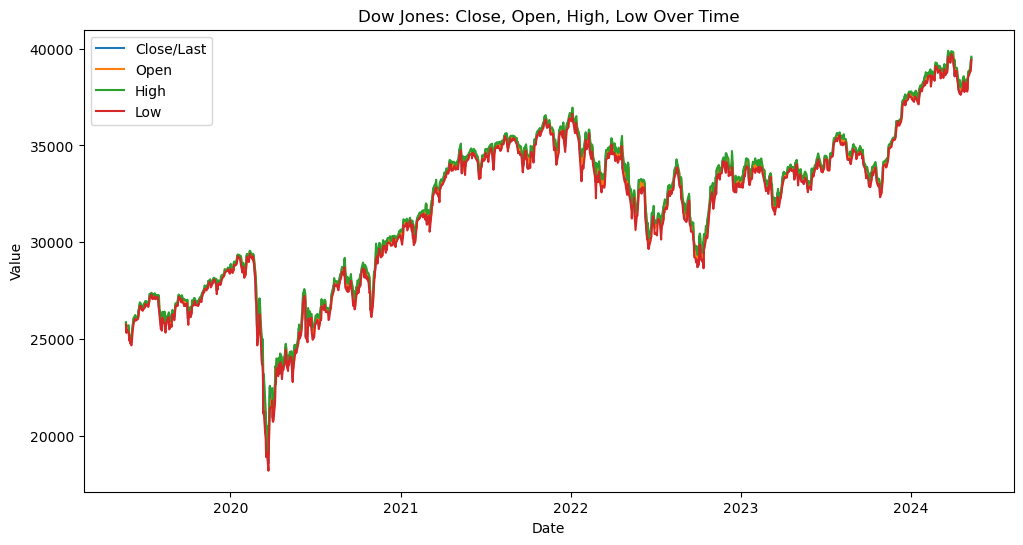

In [42]:
# Plot ilustrativo sobre los valores 'Close/Last', 'Open', 'High' and 'Low'. 
df_dow = df_dow.sort_values(by="Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close/Last', data=df_dow, label='Close/Last')
sns.lineplot(x='Date', y='Open', data=df_dow, label='Open')
sns.lineplot(x='Date', y='High', data=df_dow, label='High')
sns.lineplot(x='Date', y='Low', data=df_dow, label='Low')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Dow Jones: Close, Open, High, Low Over Time')
plt.legend(loc='upper left')
plt.show()


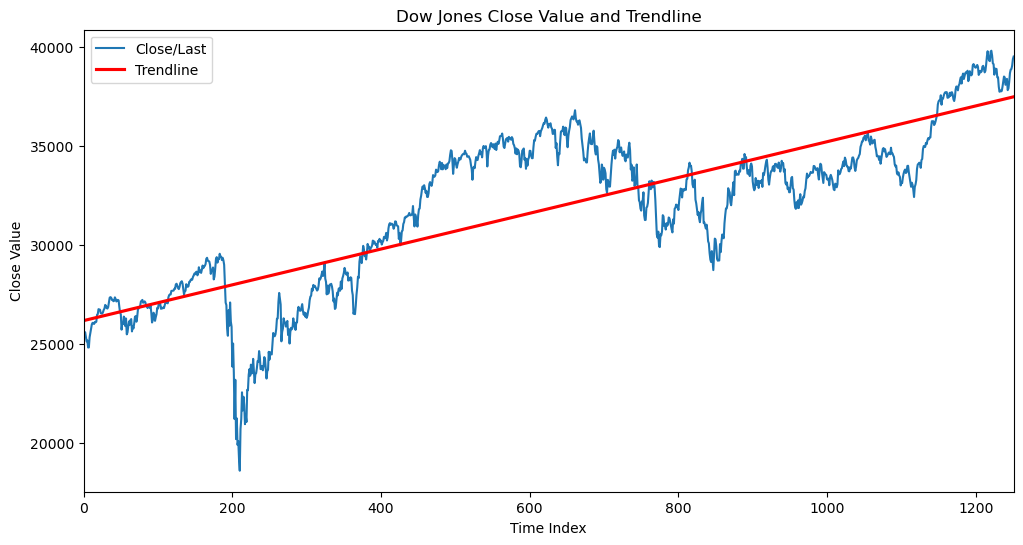

In [44]:
# Plot del valor 'Close/Last' y linea de regresion
df_dow = df_dow.sort_values(by="Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Time_index', y='Close/Last', data=df_dow, label='Close/Last')
sns.regplot(x='Time_index', y='Close/Last', data=df_dow, scatter=False, label='Trendline', ci=None, color='red')
plt.xlabel('Time Index')
plt.ylabel('Close Value')
plt.title('Dow Jones Close Value and Trendline')
plt.legend(loc='upper left')
plt.show()

In [50]:
#defino lso nobmres de los csv a utilizar
company_dates = {
"Procter":("2019-05-13", "2024-05-10"),
"3M": ("2019-05-13", "2024-05-10"),
"Merck": ("2019-05-13", "2024-05-10"),
"IBM": ("2019-05-13", "2024-05-10"),
"Amex": ("2019-05-13", "2024-05-10"),
"McDonalds": ("2019-05-13","2024-05-10"),
"Coca": ("2019-05-13", "2024-05-10"),
"Boeing": ("2019-05-13","2024-05-10"),
"JPMorgan": ("2019-05-13", "2024-05-10"),
"Dow": ("2019-05-13","2024-05-10"),
"Disney": ("2019-05-13", "2024-05-10"),
"Caterpillar": ("2019-05-13", "2024-05-10"),
"Walmart": ("2019-05-13","2024-05-10"),
"JNJ": ("2019-05-13", "2024-05-10"),
"Microsoft": ("2019-05-13","2024-05-10"),
"Intel": ("2019-05-13", "2024-05-10"),
"HomeDepot": ("2019-05-13","2024-05-10"),
"Verizon": ("2019-05-13", "2024-05-10"),
"Chevron": ("2019-05-13","2024-05-10"),
"Travelers": ("2019-05-13", "2024-05-10"),
"Cisco": ("2019-05-13","2024-05-10"),
"UnitedHealth": ("2019-05-13", "2024-05-10"),
"Visa": ("2019-05-13","2024-05-10"),
"Nike": ("2019-05-13", "2024-05-10"),
"Apple": ("2019-05-13", "2024-05-10"),
"Goldman": ("2019-04-02","2024-05-10"),
"Salesforce": ("2020-08-31","2024-05-10"),
"Honeywell": ("2020-08-31","2024-05-10"),
"Amgen": ("2020-08-31","2024-05-10"),
"Amazon": ("2024-02-26","2024-05-10"),
"Exxon":("2019-05-13", "2020-08-30"),
"Pfizer": ("2019-05-13","2020-08-30"),
"Raytheon":("2019-05-13", "2020-08-30"),
"Walgreens":("2018-06-26", "2024-02-25"),
}


In [10]:
# Creo nuevo df para mergear 
df_merge = df_dow.copy()

In [11]:
for company, (start_date, end_date) in company_dates.items():
    # cargo dataset de la compañia
    company_df = pd.read_csv(f'./datasets/companies/{company}.csv')
    company_df = company_df.applymap(convert_dollars_to_numerical)
    # Convierto a fecha  la columna date
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    
    # obtengo 
    if company in company_dates:
        start_date, end_date = company_dates[company]
        
        # Filtro por fechas
        filtered_company_df = filter_company_data(company_df, start_date, end_date)
        
        # Mergeo con mi dataset 
        df_merge = pd.merge(df_merge, filtered_company_df, on='Date', how='left', suffixes=('', f'_{company}'))

# Save the merged dataset
df_merge.to_csv('./datasets/merged_dow_jones.csv', index=False)

In [12]:
pd.set_option('display.max_columns', None) 
df_merge.head()

,Date,Close/Last,Volume,Open,High,Low,Time_index,Close/Last_Procter,Volume_Procter,Open_Procter,High_Procter,Low_Procter,Close/Last_3M,Volume_3M,Open_3M,High_3M,Low_3M,Close/Last_Merck,Volume_Merck,Open_Merck,High_Merck,Low_Merck,Close/Last_IBM,Volume_IBM,Open_IBM,High_IBM,Low_IBM,Close/Last_Amex,Volume_Amex,Open_Amex,High_Amex,Low_Amex,Close/Last_McDonalds,Volume_McDonalds,Open_McDonalds,High_McDonalds,Low_McDonalds,Close/Last_Coca,Volume_Coca,Open_Coca,High_Coca,Low_Coca,Close/Last_Boeing,Volume_Boeing,Open_Boeing,High_Boeing,Low_Boeing,Close/Last_JPMorgan,Volume_JPMorgan,Open_JPMorgan,High_JPMorgan,Low_JPMorgan,Close/Last_Dow,Volume_Dow,Open_Dow,High_Dow,Low_Dow,Close/Last_Disney,Volume_Disney,Open_Disney,High_Disney,Low_Disney,Close/Last_Caterpillar,Volume_Caterpillar,Open_Caterpillar,High_Caterpillar,Low_Caterpillar,Close/Last_Walmart,Volume_Walmart,Open_Walmart,High_Walmart,Low_Walmart,Close/Last_JNJ,Volume_JNJ,Open_JNJ,High_JNJ,Low_JNJ,Close/Last_Microsoft,Volume_Microsoft,Open_Microsoft,High_Microsoft,Low_Microsoft,Close/Last_Intel,Volume_Intel,Open_Intel,High_Intel,Low_Intel,Close/Last_HomeDepot,Volume_HomeDepot,Open_HomeDepot,High_HomeDepot,Low_HomeDepot,Close/Last_Verizon,Volume_Verizon,Open_Verizon,High_Verizon,Low_Verizon,Close/Last_Chevron,Volume_Chevron,Open_Chevron,High_Chevron,Low_Chevron,Close/Last_Travelers,Volume_Travelers,Open_Travelers,High_Travelers,Low_Travelers,Close/Last_Cisco,Volume_Cisco,Open_Cisco,High_Cisco,Low_Cisco,Close/Last_UnitedHealth,Volume_UnitedHealth,Open_UnitedHealth,High_UnitedHealth,Low_UnitedHealth,Close/Last_Visa,Volume_Visa,Open_Visa,High_Visa,Low_Visa,Close/Last_Nike,Volume_Nike,Open_Nike,High_Nike,Low_Nike,Close/Last_Apple,Volume_Apple,Open_Apple,High_Apple,Low_Apple,Close/Last_Goldman,Volume_Goldman,Open_Goldman,High_Goldman,Low_Goldman,Close/Last_Salesforce,Volume_Salesforce,Open_Salesforce,High_Salesforce,Low_Salesforce,Close/Last_Honeywell,Volume_Honeywell,Open_Honeywell,High_Honeywell,Low_Honeywell,Close/Last_Amgen,Volume_Amgen,Open_Amgen,High_Amgen,Low_Amgen,Close/Last_Amazon,Volume_Amazon,Open_Amazon,High_Amazon,Low_Amazon,Close/Last_Exxon,Volume_Exxon,Open_Exxon,High_Exxon,Low_Exxon,Close/Last_Pfizer,Volume_Pfizer,Open_Pfizer,High_Pfizer,Low_Pfizer,Close/Last_Raytheon,Volume_Raytheon,Open_Raytheon,High_Raytheon,Low_Raytheon,Close/Last_Walgreens,Volume_Walgreens,Open_Walgreens,High_Walgreens,Low_Walgreens
0,2019-05-22,25776.61,NaN,25818.46,25878.21,25755.11,0,106.72,4889697,106.09,107.050,105.940,145.7040,4504159,143.7211,146.5796,142.8885,78.1515,12873870,76.5784,78.3156,76.5398,131.9741,1849821,131.6353,132.3613,131.3562,120.01,2941084,120.36,120.88,119.4400,199.96,1760440,199.52,200.17,198.50,49.65,16050700,48.78,49.71,48.7200,352.78,3841430,357.22,357.57,351.75,110.82,7918898,111.40,111.79,110.75,50.21,3019120,50.46,50.610,49.965,133.85,5093746,133.82,134.17,133.3900,123.56,4620431,124.25,125.4393,123.52,34.0767,22022627,33.8667,34.1433,33.6867,138.76,5456839,138.35,138.95,137.485,127.67,15396490,126.62,128.240,126.52,44.00,16932520,44.15,44.46,43.8450,188.91,5706339,190.49,192.22,188.05,59.25,11487450,59.09,59.3700,58.96,120.57,5763543,120.90,121.435,120.340,147.96,1104158,147.48,148.2616,146.94,55.69,19479170,56.22,56.30,55.670,249.34,4038028,249.10,251.0300,248.71,164.24,5416382,163.60,165.63,163.45,83.20,5237761,82.99,83.34,82.76,45.6950,118994240,46.165,46.4275,45.6375,195.52,2427247,197.44,198.48,195.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.56,7858317.0,76.02,76.22,75.385,41.0440,23979960.0,40.7508,41.2591,40.6139,80.2919,1942732.0,80.2623,80.8315,80.0133,52.94,3372200.0,52.77,53.01,52.390
1,2019-05-23,25490.47,NaN,25657.99,25657.99,25328.09,1,106.76,6175566,106.68,107.030,105.885,142.3820,3830288,143.8499,144.4679,141.2833,78.1901,9381160,77.7848,78.3542,77.6014,128.1412,5343437,130.7933,130.7933,126.2538,118.43,3290185,119.27,119.40,117.8500,198.97,3560545,198.81,199.43,198.10,49.85,12199510,49.50,49.90,49.4601,350.5

In [51]:
# Filtro los datos para crear un nuevo dataframe con los valores de "Date" y "Close/Last"

df_columns = df_merge.columns.values.tolist()

regex = 'Close'
date = 'Date'
list_close_last = [ x for x in df_columns if re.search(regex, x) or re.search(date, x)]

print(list_close_last)

df_close_last = df_merge[list_close_last]


['Date', 'Close/Last', 'Close/Last_Procter', 'Close/Last_3M', 'Close/Last_Merck', 'Close/Last_IBM', 'Close/Last_Amex', 'Close/Last_McDonalds', 'Close/Last_Coca', 'Close/Last_Boeing', 'Close/Last_JPMorgan', 'Close/Last_Dow', 'Close/Last_Disney', 'Close/Last_Caterpillar', 'Close/Last_Walmart', 'Close/Last_JNJ', 'Close/Last_Microsoft', 'Close/Last_Intel', 'Close/Last_HomeDepot', 'Close/Last_Verizon', 'Close/Last_Chevron', 'Close/Last_Travelers', 'Close/Last_Cisco', 'Close/Last_UnitedHealth', 'Close/Last_Visa', 'Close/Last_Nike', 'Close/Last_Apple', 'Close/Last_Goldman', 'Close/Last_Salesforce', 'Close/Last_Honeywell', 'Close/Last_Amgen', 'Close/Last_Amazon', 'Close/Last_Exxon', 'Close/Last_Pfizer', 'Close/Last_Raytheon', 'Close/Last_Walgreens']


In [52]:
df_close_last.head(3)

,Date,Close/Last,Close/Last_Procter,Close/Last_3M,Close/Last_Merck,Close/Last_IBM,Close/Last_Amex,Close/Last_McDonalds,Close/Last_Coca,Close/Last_Boeing,Close/Last_JPMorgan,Close/Last_Dow,Close/Last_Disney,Close/Last_Caterpillar,Close/Last_Walmart,Close/Last_JNJ,Close/Last_Microsoft,Close/Last_Intel,Close/Last_HomeDepot,Close/Last_Verizon,Close/Last_Chevron,Close/Last_Travelers,Close/Last_Cisco,Close/Last_UnitedHealth,Close/Last_Visa,Close/Last_Nike,Close/Last_Apple,Close/Last_Goldman,Close/Last_Salesforce,Close/Last_Honeywell,Close/Last_Amgen,Close/Last_Amazon,Close/Last_Exxon,Close/Last_Pfizer,Close/Last_Raytheon,Close/Last_Walgreens
0,2019-05-22,25776.61,106.72,145.7040,78.1515,131.9741,120.01,199.96,49.65,352.78,110.82,50.21,133.85,123.56,34.0767,138.76,127.67,44.00,188.91,59.25,120.57,147.96,55.69,249.34,164.24,83.20,45.6950,195.52,NaN,NaN,NaN,NaN,75.56,41.0440,80.2919,52.94
1,2019-05-23,25490.47,106.76,142.3820,78.1901,128.1412,118.43,198.97,49.85,350.55,108.64,48.71,132.73,122.26,33.9533,139.79,126.18,44.53,192.00,58.87,117.87,146.94,54.19,246.50,161.51,82.64,44.9150,191.97,NaN,NaN,NaN,NaN,73.79,40.9756,77.3509,51.61
2,2019-05-24,25585.69,106.69,142.5709,78.3349,128.0347,119.51,197.77,49.61,354.90,109.71,49.20,132.79,122.90,34.2233,138.85,126.24,44.57,193.59,59.32,118.71,147.94,54.37,247.63,162.64,82.16,44.7425,193.00,NaN,NaN,NaN,NaN,74.10,41.0049,77.9142,51.77


In [53]:
# Renombrar columnas para mayor claridad
rename_function = lambda name: 'Index' if name == 'Close/Last' else name.split('_')[-1]

# Funcion para renombrar
new_column_names = list(map(rename_function, list_close_last))

df_close_last.rename(columns=dict(zip(df_close_last.columns, new_column_names)), inplace=True)

df_close_last.head()

/Users/juanvassallo/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-22,25776.61,106.72,145.7040,78.1515,131.9741,120.01,199.96,49.65,352.78,110.82,50.21,133.85,123.56,34.0767,138.76,127.67,44.00,188.91,59.25,120.57,147.96,55.69,249.34,164.24,83.20,45.6950,195.52,NaN,NaN,NaN,NaN,75.56,41.0440,80.2919,52.94
1,2019-05-23,25490.47,106.76,142.3820,78.1901,128.1412,118.43,198.97,49.85,350.55,108.64,48.71,132.73,122.26,33.9533,139.79,126.18,44.53,192.00,58.87,117.87,146.94,54.19,246.50,161.51,82.64,44.9150,191.97,NaN,NaN,NaN,NaN,73.79,40.9756,77.3509,51.61
2,2019-05-24,25585.69,106.69,142.5709,78.3349,128.0347,119.51,197.77,49.61,354.90,109.71,49.20,132.79,122.90,34.2233,138.85,126.24,44.57,193.59,59.32,118.71,147.94,54.37,247.63,162.64,82.16,44.7425,193.00,NaN,NaN,NaN,NaN,74.10,41.0049,77.9142,51.77
3,2019-05-28,25347.77,104.46,140.2189,77.4567,126.2731,118.17,196.67,49.10,354.88,108.52,48.56,132.62,121.59,34.1400,137.07,126.16,43.57,191.55,58.73,118.31,146.28,53.93,242.06,163.71,81.20,44.5575,189.44,NaN,NaN,NaN,NaN,72.61,40.9560,77.0366,51.69
4,2019-05-29,25126.41,104.19,138.5450,76.5881,125.5278,117.01,196.02,48.61,348.80,108.22,48.71,131.57,121.48,34.0400,131.33,124.94,44.23,189.99,58.18,116.77,145.07,53.18,242.40,162.73,78.87,44.3450,188.05,NaN,NaN,NaN,NaN,72.16,40.7801,76.7698,51.13


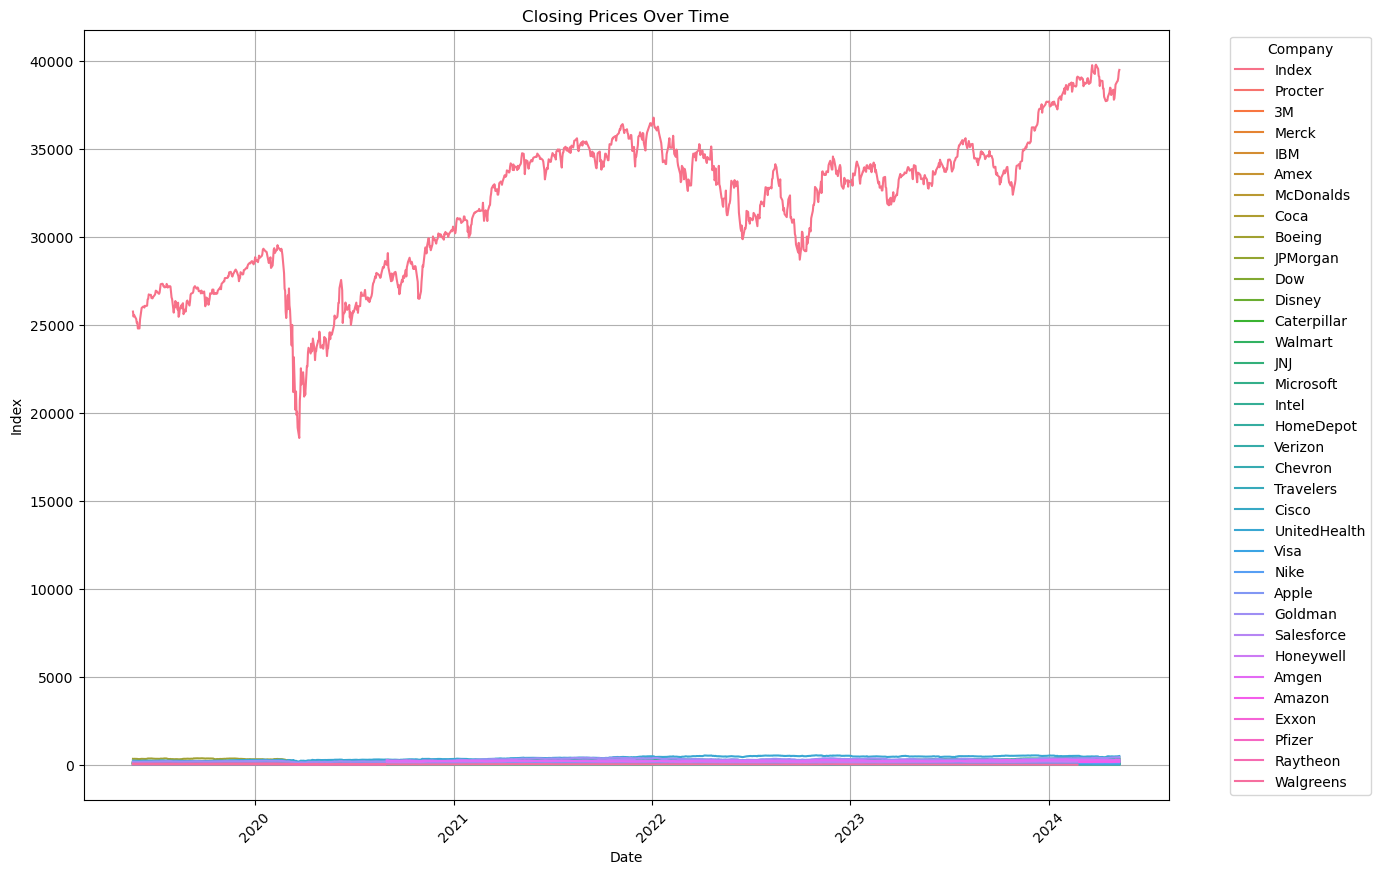

In [54]:
# Plot de los valores para cada empresa

melted_df = df_close_last.melt(id_vars=['Date'], var_name='Company', value_name='Close_value')

plt.figure(figsize=(14, 10))
sns.lineplot(data=melted_df, x='Date', y='Close_value', hue='Company')

plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [55]:
# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)


                 Index   Procter        3M     Merck       IBM      Amex  \
Index         1.000000  0.858189 -0.287993  0.575234  0.654582  0.925775   
Procter       0.858189  1.000000 -0.418161  0.585394  0.480363  0.771185   
3M           -0.287993 -0.418161  1.000000 -0.838995 -0.426092 -0.350114   
Merck         0.575234  0.585394 -0.838995  1.000000  0.700565  0.617275   
IBM           0.654582  0.480363 -0.426092  0.700565  1.000000  0.714595   
Amex          0.925775  0.771185 -0.350114  0.617275  0.714595  1.000000   
McDonalds     0.846866  0.831303 -0.630025  0.787436  0.597773  0.797418   
Coca          0.692758  0.733965 -0.456820  0.623064  0.496785  0.742283   
Boeing       -0.209440 -0.430104  0.337648 -0.168961  0.100821 -0.128645   
JPMorgan      0.889740  0.632772 -0.123405  0.471687  0.692082  0.861999   
Dow           0.710836  0.534186  0.242192  0.091238  0.309714  0.658027   
Disney       -0.002089 -0.228755  0.887396 -0.667067 -0.235276 -0.064350   
Caterpillar 

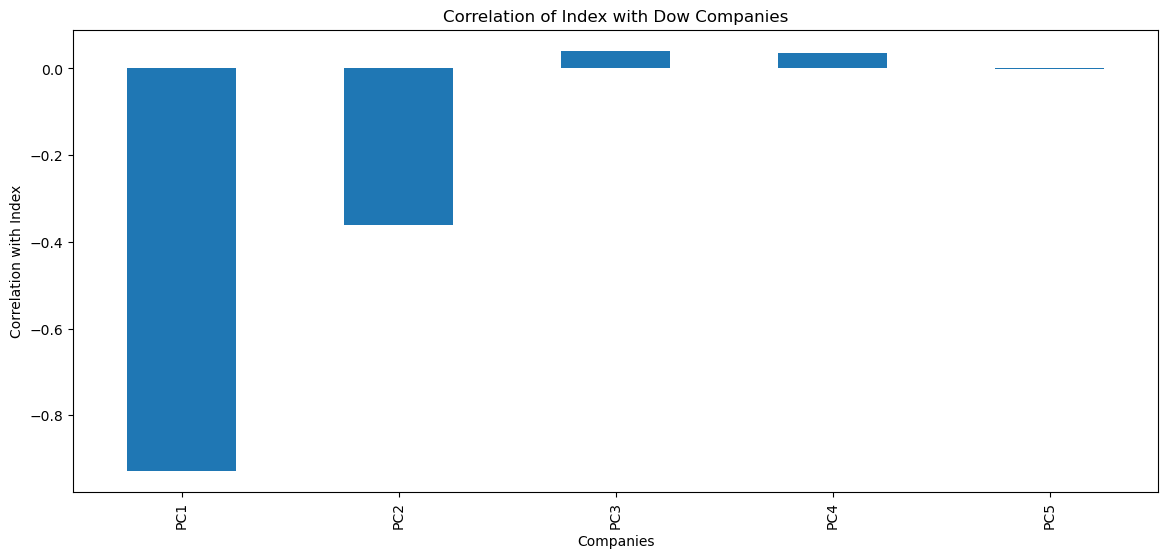

In [56]:
# Correlacion de las empresas con el Dow Index
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation with Index')
plt.title('Correlation of Index with Dow Companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

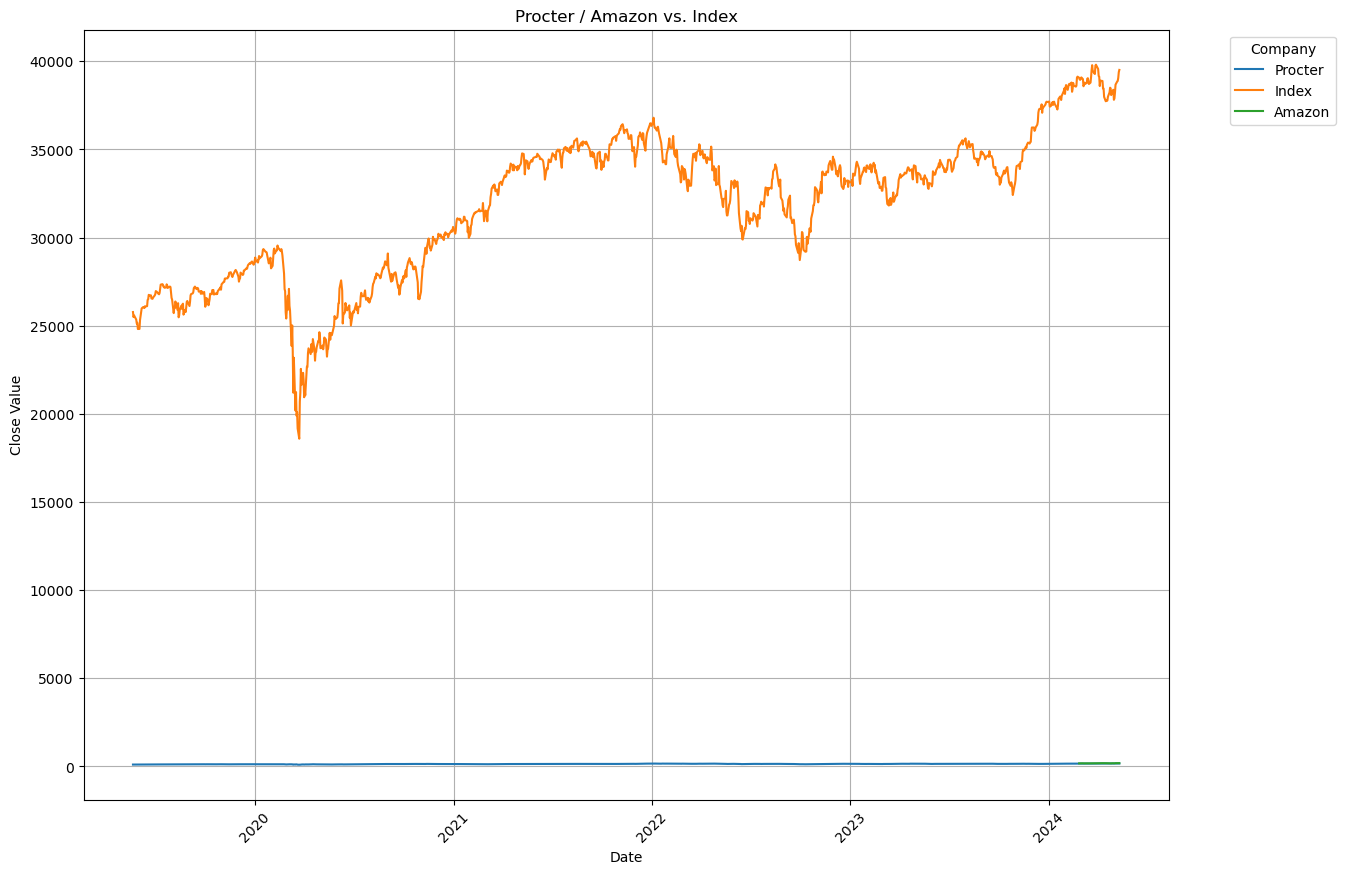

In [57]:
# Comparación de Procter, Amazon e Index
plt.figure(figsize=(14, 10))
sns.lineplot(x='Date', y='Procter', data=df_close_last, label='Procter')
sns.lineplot(x='Date', y='Index', data=df_close_last, label='Index')
sns.lineplot(x='Date', y='Amazon', data=df_close_last, label='Amazon')
plt.title('Procter / Amazon vs. Index')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [20]:
df_close_last.head(2)

,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-22,25776.61,106.72,145.704,78.1515,131.9741,120.01,199.96,49.65,352.78,110.82,50.21,133.85,123.56,34.0767,138.76,127.67,44.00,188.91,59.25,120.57,147.96,55.69,249.34,164.24,83.20,45.695,195.52,NaN,NaN,NaN,NaN,75.56,41.0440,80.2919,52.94
1,2019-05-23,25490.47,106.76,142.382,78.1901,128.1412,118.43,198.97,49.85,350.55,108.64,48.71,132.73,122.26,33.9533,139.79,126.18,44.53,192.00,58.87,117.87,146.94,54.19,246.50,161.51,82.64,44.915,191.97,NaN,NaN,NaN,NaN,73.79,40.9756,77.3509,51.61


In [21]:
#creo un df de resultados de las primeras predicciones
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["PriceShift1"] = data_train[target_column].shift()
/Users/juanvassallo/anaconda3/envs/dhdsblend2021/lib/python3.8/site-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

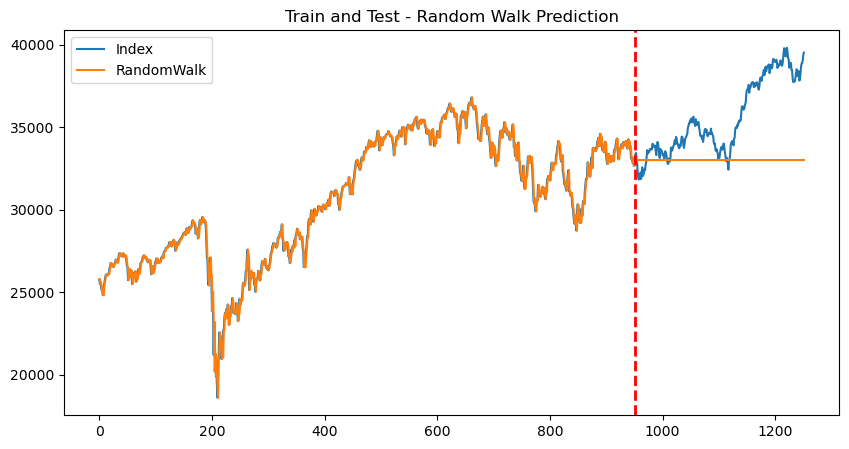

         Model     RMSE
0  Random Walk  3382.57


In [22]:
random_walk_pred(df_close_last,'Index', 300)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Mean'] = model_mean_pred
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Mean'] = model_mean_pred


Mean:  30662.55807773109


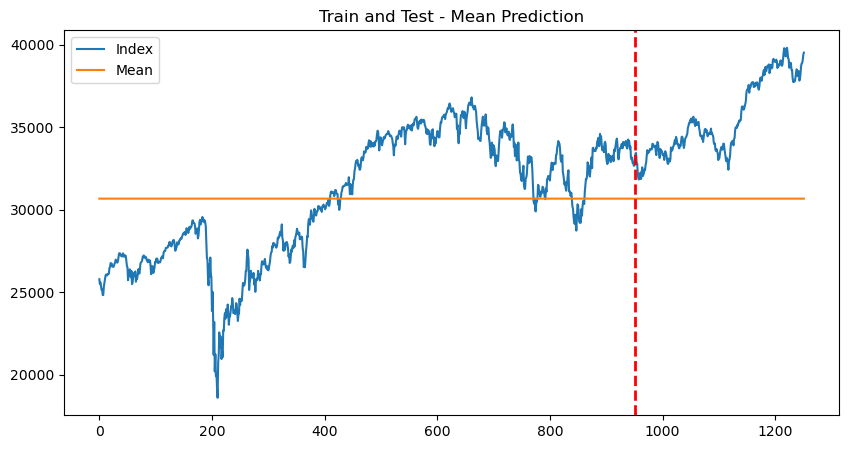

         Model     RMSE
0  Random Walk  3382.57
1         Mean  5358.65


In [23]:
mean_pred(df_close_last,'Index', 300)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["LinearTrend"] = model_linear.predict(data_train.timeIndex)
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["LinearTrend"] = model_linear.predict(data_test.timeIndex)


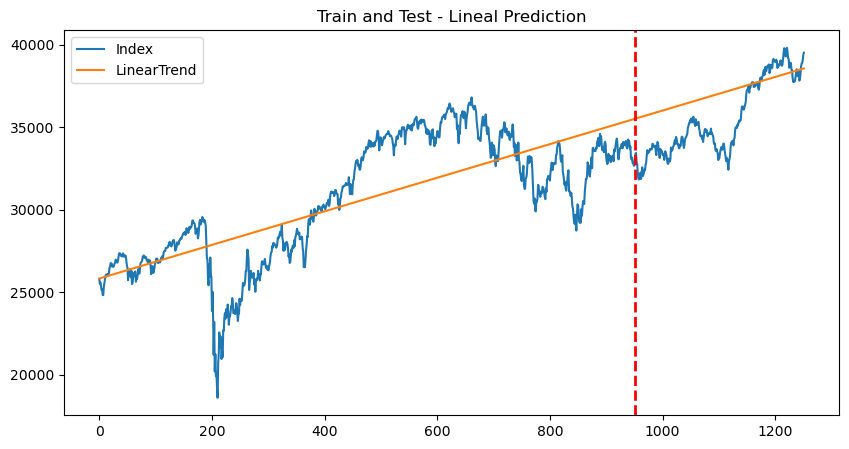

         Model     RMSE
0  Random Walk  3382.57
1         Mean  5358.65
2  LinearTrend  2151.64

                            OLS Regression Results                            
Dep. Variable:                  Index   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     1184.
Date:                Fri, 04 Jul 2025   Prob (F-statistic):          3.76e-169
Time:                        14:53:45   Log-Likelihood:                -8801.4
No. Observations:                 952   AIC:                         1.761e+04
Df Residuals:                     950   BIC:                         1.762e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [24]:
lineal_pred(df_close_last,'Index', 300)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["ExpTrend"] = model_exp.predict(data_train[["timeIndex","timeIndex_exp"]])
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["ExpTrend"] = model_exp.predict(data_test[["timeIndex","timeIndex_exp"]])


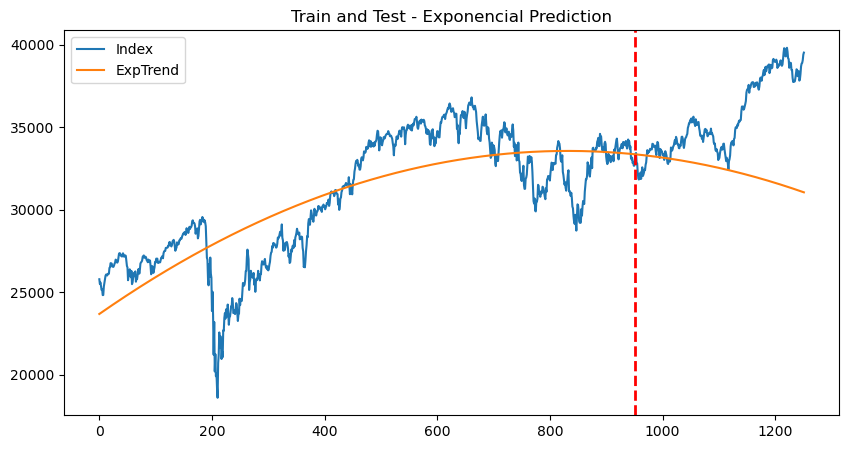

         Model     RMSE
0  Random Walk  3382.57
1         Mean  5358.65
2  LinearTrend  2151.64
3     ExpTrend  4241.91

                            OLS Regression Results                            
Dep. Variable:                  Index   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     777.0
Date:                Fri, 04 Jul 2025   Prob (F-statistic):          1.38e-200
Time:                        14:53:45   Log-Likelihood:                -8725.0
No. Observations:                 952   AIC:                         1.746e+04
Df Residuals:                     949   BIC:                         1.747e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------

In [25]:
exp_pred(df_close_last,'Index', 300)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['log_target'] = np.log(data_train[target_column])
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['log_target'] = np.log(data_test[target_column])
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/1663467710.py:165: SettingWithCopyWarning: 
A value is trying to be

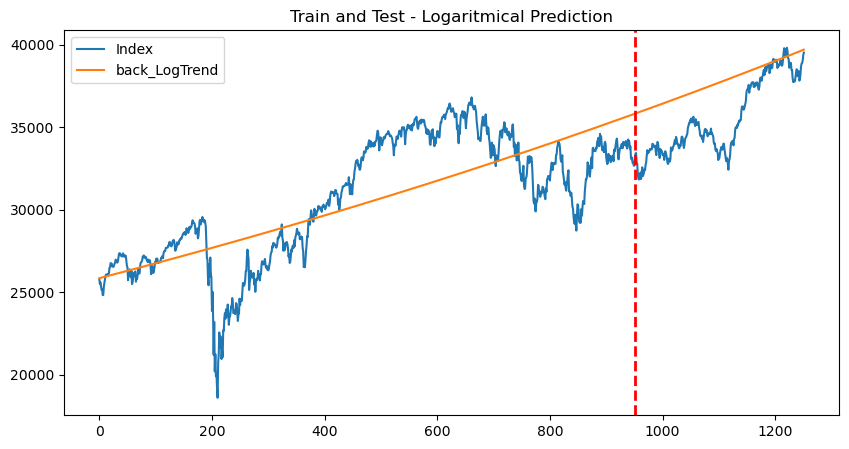

           Model     RMSE
0    Random Walk  3382.57
1           Mean  5358.65
2    LinearTrend  2151.64
3       ExpTrend  4241.91
4  back_LogTrend  2590.44

                            OLS Regression Results                            
Dep. Variable:             log_target   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     1150.
Date:                Fri, 04 Jul 2025   Prob (F-statistic):          8.74e-166
Time:                        14:53:45   Log-Likelihood:                 988.01
No. Observations:                 952   AIC:                            -1972.
Df Residuals:                     950   BIC:                            -1962.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t

In [26]:
log_pred(df_close_last,'Index', 300)

['Procter', '3M', 'Merck', 'IBM', 'Amex', 'McDonalds', 'Coca', 'Boeing', 'JPMorgan', 'Dow', 'Disney', 'Caterpillar', 'Walmart', 'JNJ', 'Microsoft', 'Intel', 'HomeDepot', 'Verizon', 'Chevron', 'Travelers', 'Cisco', 'UnitedHealth', 'Visa', 'Nike', 'Apple', 'Goldman', 'Salesforce', 'Honeywell', 'Amgen', 'Amazon', 'Exxon', 'Pfizer', 'Raytheon', 'Walgreens']


/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_14412/884778296.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  feature_data = df_close_last[features].fillna(df_close_last.mean())


Explained variance by component: [0.44934296 0.17593234 0.10740557 0.07351516 0.0329218 ]
          Index           PC1           PC2           PC3           PC4  \
Index  1.000000 -9.278568e-01 -3.601536e-01  4.121191e-02  3.639796e-02   
PC1   -0.927857  1.000000e+00  1.386405e-16 -7.503116e-17 -2.240884e-16   
PC2   -0.360154  1.386405e-16  1.000000e+00 -5.892509e-16 -7.836293e-17   
PC3    0.041212 -7.503116e-17 -5.892509e-16  1.000000e+00 -6.245925e-17   
PC4    0.036398 -2.240884e-16 -7.836293e-17 -6.245925e-17  1.000000e+00   
PC5   -0.000228 -7.548122e-18  1.629189e-16  2.105295e-17 -1.408072e-16   

                PC5  
Index -2.277436e-04  
PC1   -7.548122e-18  
PC2    1.629189e-16  
PC3    2.105295e-17  
PC4   -1.408072e-16  
PC5    1.000000e+00  


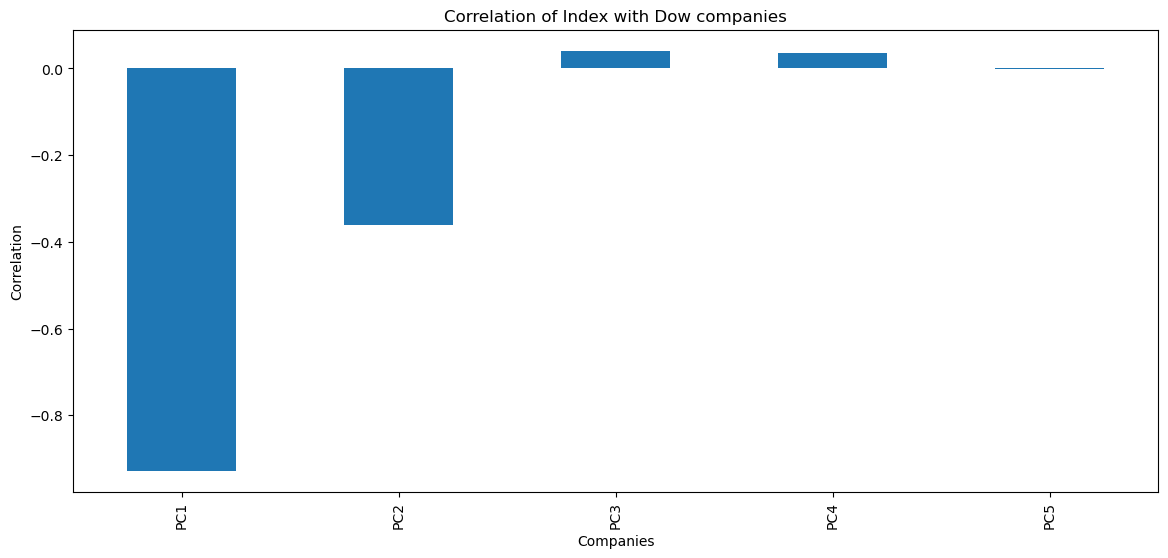

In [27]:
#Selecciono mis features
features = [col for col in df_close_last.columns]
features.remove('Date')
features.remove('Index')
#features = [col for col in df_close_last.columns if col not in ['Date', 'Index']]
print(features)
# Extrigo
feature_data = df_close_last[features].fillna(df_close_last.mean())

# Normalizo
scaler = StandardScaler()
scaled_feature_data = scaler.fit_transform(feature_data)

# Aplico pca
pca = PCA(n_components=5) 
principal_components = pca.fit_transform(scaled_feature_data)

# Creo DF para los componentes principales 
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

df_close_last = pd.concat([df_close_last[['Index']],df_close_last[['Date']], pc_df], axis=1)
df_close_last.head()

# Ratio de Varianza
explained_variance = pca.explained_variance_ratio_
print('Explained variance by component:', explained_variance)

# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)

# Correlacion de las empresas con el Dow Index
# Son demasiadas empresas, por lo tanto las correlaciones se muestran mejor como grafico de histogramas
# Transposicion de la matriz
correlation_matrix = correlation_matrix[['Index']].transpose()

# Todas las correlaciones a partir de la segunda columna
correlations = correlation_matrix.loc['Index', 'PC1':]

# Plot 
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation')
plt.title('Correlation of Index with Dow companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Modelo ARIMA

In [28]:
df_close_last.head(2)

,Index,Date,PC1,PC2,PC3,PC4,PC5
0,25776.61,2019-05-22,5.696852,-0.480091,-4.827449,-0.376009,-0.536273
1,25490.47,2019-05-23,5.842682,-0.135840,-4.381576,-0.351710,-0.462056


In [29]:
dfa = df_close_last.copy()

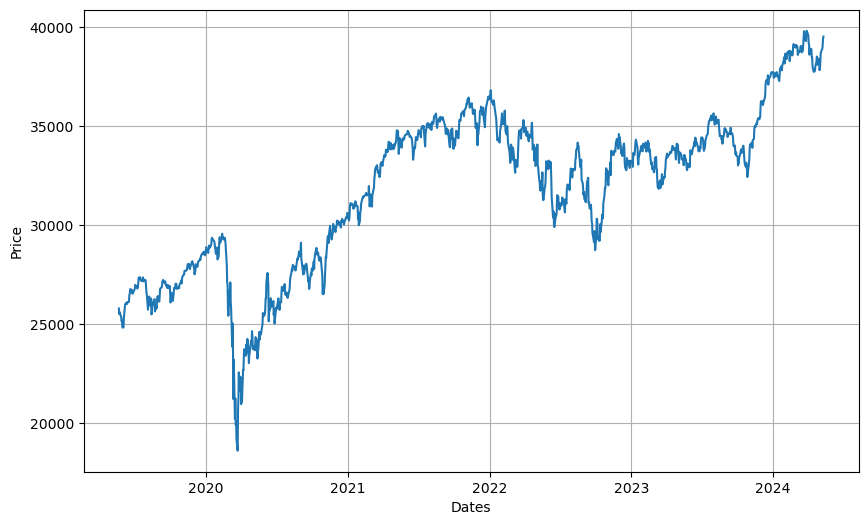

In [30]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa["Date"],dfa['Index'])
plt.show()

In [31]:
dfa_train, dfa_test = train_test_split(dfa, test_size=300, random_state=2024, shuffle=False)

In [32]:
dfa_train.columns

Index(['Index', 'Date', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'], dtype='object')

In [33]:
#columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
modela = auto_arima(y = dfa_train['Index'], exogenous = dfa_train[columns], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13978.606, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14049.921, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14031.333, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14034.965, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14048.282, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14023.680, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14025.014, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13978.108, Time=0.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14026.540, Time=0.28 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13980.038, Time=1.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=13978.922, Time=1.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14026.511, Time=0.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13986.069, Time=0.72 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=13981.881, Time=1.12 sec
 ARIMA(3,1,2)(0,0,0

In [34]:
modela.fit(dfa_train['Index'],dfa_train[columns])

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [35]:
# Ajustar el modelo con datos de entrenamiento
modela = ARIMA(dfa_train['Index'], exog=dfa_train[columns], order = (3,1,2))
modela_fit = modela.fit()

# Predecir con datos de prueba
forecasta2 = modela_fit.predict(start=len(dfa_train), end=len(dfa_train) + len(dfa_test) - 1, exog=dfa_test[columns])

# Mostrar resultados
print(forecasta2)

/Users/juanvassallo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/juanvassallo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


952     33369.195998
953     33415.829786
954     32862.588502
955     32804.326976
956     32269.778007
            ...     
1247    39117.016707
1248    39259.075417
1249    39448.305201
1250    39680.465835
1251    39842.804772
Name: predicted_mean, Length: 300, dtype: float64


In [36]:
forecasta2.dtype

index = range(952, 952 + len(forecasta2))
series = pd.Series(forecasta2, index=index, name='value')

# Convertir la Serie en un DataFrame
df_forecasta = pd.DataFrame(series)

# Asignar el valor de la columna 'date' del DataFrame 2 al DataFrame 1
df_forecasta['date'] = dfa.loc[960:, "Date"]


print(df_forecasta.tail(10))

             value       date
1242  38913.287408 2024-04-29
1243  38430.375453 2024-04-30
1244  38440.003782 2024-05-01
1245  38601.329653 2024-05-02
1246  38927.480396 2024-05-03
1247  39117.016707 2024-05-06
1248  39259.075417 2024-05-07
1249  39448.305201 2024-05-08
1250  39680.465835 2024-05-09
1251  39842.804772 2024-05-10


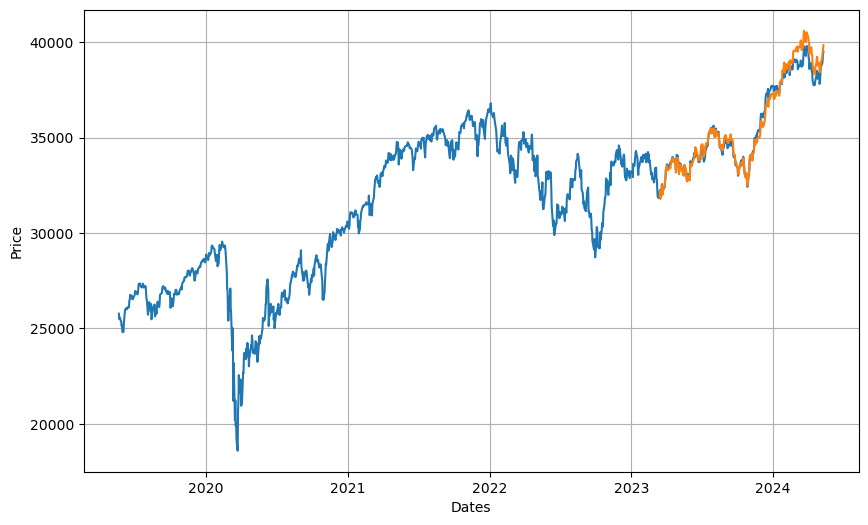

In [37]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(dfa["Date"],dfa['Index'])
plt.plot(df_forecasta["date"],df_forecasta["value"])
plt.show()

In [38]:
RMSE(forecasta2,dfa_test['Index'])

372.88253548443186

In [39]:
dfb = dfa.copy()
columns = (['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
target_column = 'Index'

# Asegurarse de que 'Date' esté en el índice
dfb['Date'] = pd.to_datetime(dfb['Date'])
dfb.set_index('Date', inplace=True)

# Ajustar el modelo ARIMA con todos los datos disponibles
modela = ARIMA(dfb[target_column], exog=dfb[columns])
modela_fit = modela.fit()

# Crear DataFrame para los próximos 60 días
last_date = dfb.index[-1]
future_dates = pd.date_range(start=last_date, periods=60)

# Generar tendencias para las variables exógenas futuras (esto es solo un ejemplo)
future_exog = pd.DataFrame(index=future_dates)

for col in columns:
    # Preparar los datos para la regresión lineal
    X = np.arange(len(df_close_last)).reshape(-1, 1)
    y = df_close_last[col].values
    
    # Ajustar el modelo de regresión lineal
    model_exog = LinearRegression()
    model_exog.fit(X, y)
    
    # Predecir los próximos 60 días
    X_future = np.arange(len(df_close_last), len(df_close_last) + 60).reshape(-1, 1)
    future_exog[col] = model_exog.predict(X_future)



# Predecir los próximos 60 registros si no hay NaN en future_exog
if not future_exog.isnull().values.any():
    forecasta_future = modela_fit.forecast(steps=60, exog=future_exog)
    # Mostrar resultados
    print(forecasta_future)
else:
    print("Future exogenous variables contain NaN values. Please check the models.")

/Users/juanvassallo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/juanvassallo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/juanvassallo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1252    37469.174668
1253    37478.180458
1254    37487.186248
1255    37496.192038
1256    37505.197828
1257    37514.203619
1258    37523.209409
1259    37532.215199
1260    37541.220989
1261    37550.226779
1262    37559.232569
1263    37568.238360
1264    37577.244150
1265    37586.249940
1266    37595.255730
1267    37604.261520
1268    37613.267311
1269    37622.273101
1270    37631.278891
1271    37640.284681
1272    37649.290471
1273    37658.296261
1274    37667.302052
1275    37676.307842
1276    37685.313632
1277    37694.319422
1278    37703.325212
1279    37712.331002
1280    37721.336793
1281    37730.342583
1282    37739.348373
1283    37748.354163
1284    37757.359953
1285    37766.365743
1286    37775.371534
1287    37784.377324
1288    37793.383114
1289    37802.388904
1290    37811.394694
1291    37820.400484
1292    37829.406275
1293    37838.412065
1294    37847.417855
1295    37856.423645
1296    37865.429435
1297    37874.435225
1298    37883.441016
1299    37892

/Users/juanvassallo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/juanvassallo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [60]:
import holidays
from datetime import timedelta
index = range(1252, 1252 + len(forecasta_future))
series = pd.Series(forecasta_future, index=index, name='value')

df_forecasta_future = pd.DataFrame(series)

start_date = pd.Timestamp('2024-05-23') + timedelta(days=1) 
end_date = start_date + timedelta(days=90)

us_holidays = holidays.US()

def is_business_day(date):
    return date.weekday() < 5 and date not in us_holidays

business_dates = [date for date in pd.date_range(start=start_date, end=end_date) if is_business_day(date)]

df_new = pd.DataFrame({'date': business_dates})
df_new.index += 1252

df_forecasta_future["date"]=df_new["date"] 



print(df_forecasta_future)

             value       date
1252  37469.174668 2024-05-24
1253  37478.180458 2024-05-28
1254  37487.186248 2024-05-29
1255  37496.192038 2024-05-30
1256  37505.197828 2024-05-31
1257  37514.203619 2024-06-03
1258  37523.209409 2024-06-04
1259  37532.215199 2024-06-05
1260  37541.220989 2024-06-06
1261  37550.226779 2024-06-07
1262  37559.232569 2024-06-10
1263  37568.238360 2024-06-11
1264  37577.244150 2024-06-12
1265  37586.249940 2024-06-13
1266  37595.255730 2024-06-14
1267  37604.261520 2024-06-17
1268  37613.267311 2024-06-18
1269  37622.273101 2024-06-20
1270  37631.278891 2024-06-21
1271  37640.284681 2024-06-24
1272  37649.290471 2024-06-25
1273  37658.296261 2024-06-26
1274  37667.302052 2024-06-27
1275  37676.307842 2024-06-28
1276  37685.313632 2024-07-01
1277  37694.319422 2024-07-02
1278  37703.325212 2024-07-03
1279  37712.331002 2024-07-05
1280  37721.336793 2024-07-08
1281  37730.342583 2024-07-09
1282  37739.348373 2024-07-10
1283  37748.354163 2024-07-11
1284  3775

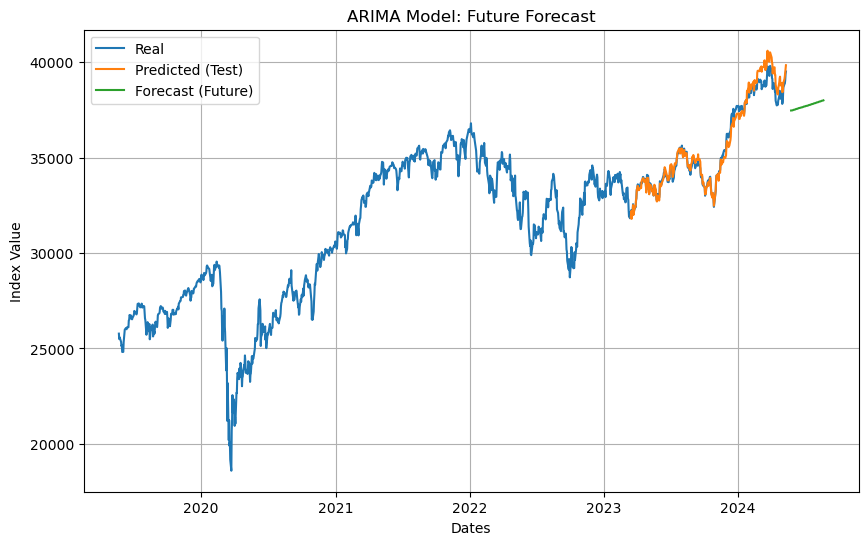

In [61]:
# ARIMA: Predicción a futuro
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Index Value')
plt.title('ARIMA Model: Future Forecast')
plt.plot(dfa["Date"], dfa['Index'], label='Real')
plt.plot(df_forecasta["date"], df_forecasta["value"], label='Predicted (Test)')
plt.plot(df_forecasta_future["date"], df_forecasta_future["value"], label='Forecast (Future)')
plt.legend()
plt.show()

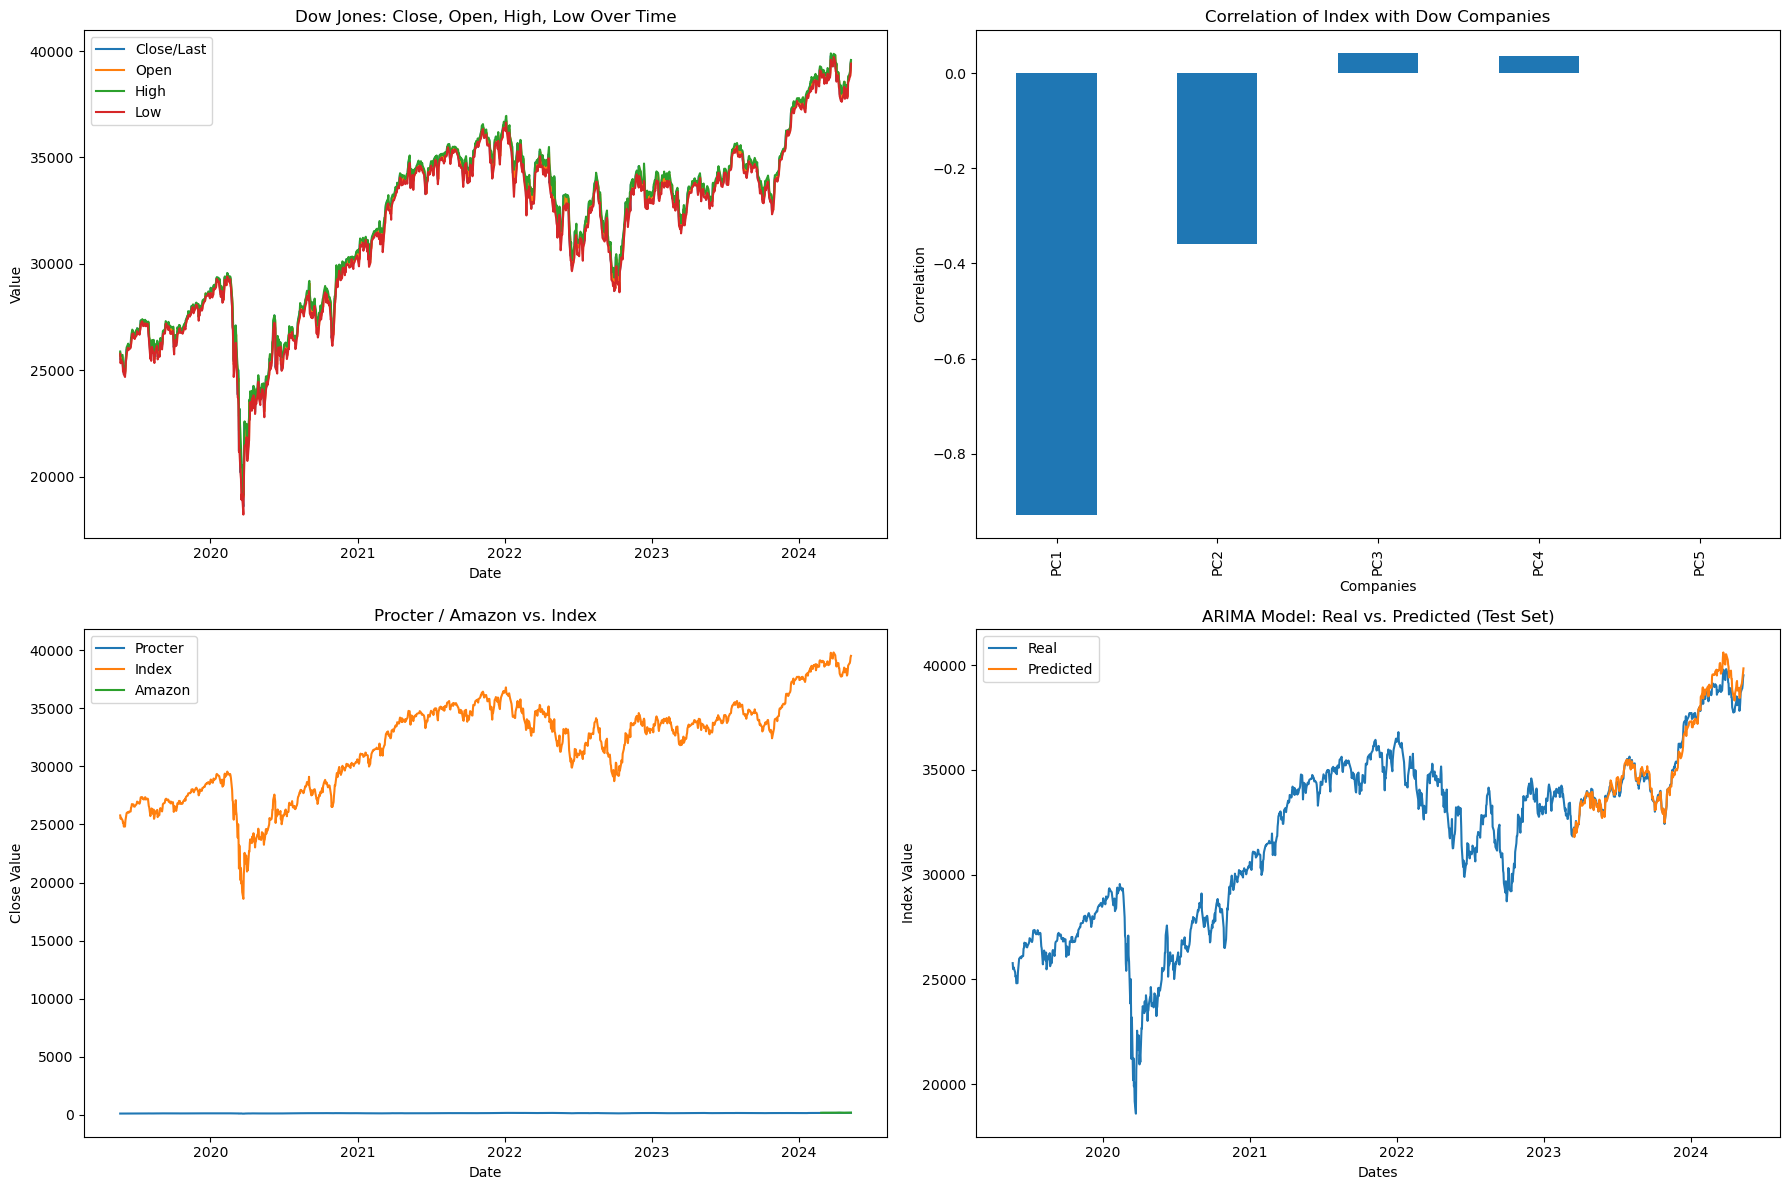

In [62]:
# Comparativa de los 4 gráficos más relevantes

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# 1. Dow Jones: Close, Open, High, Low Over Time
sns.lineplot(x='Date', y='Close/Last', data=df_dow, label='Close/Last', ax=axs[0,0])
sns.lineplot(x='Date', y='Open', data=df_dow, label='Open', ax=axs[0,0])
sns.lineplot(x='Date', y='High', data=df_dow, label='High', ax=axs[0,0])
sns.lineplot(x='Date', y='Low', data=df_dow, label='Low', ax=axs[0,0])
axs[0,0].set_title('Dow Jones: Close, Open, High, Low Over Time')
axs[0,0].set_xlabel('Date')
axs[0,0].set_ylabel('Value')
axs[0,0].legend()

# 2. Correlation of Index with Dow Companies
correlations.plot(kind='bar', ax=axs[0,1])
axs[0,1].set_title('Correlation of Index with Dow Companies')
axs[0,1].set_xlabel('Companies')
axs[0,1].set_ylabel('Correlation')
axs[0,1].tick_params(axis='x', rotation=90)

# 3. Procter / Amazon vs. Index
sns.lineplot(x='Date', y='Procter', data=df_close_last, label='Procter', ax=axs[1,0])
sns.lineplot(x='Date', y='Index', data=df_close_last, label='Index', ax=axs[1,0])
sns.lineplot(x='Date', y='Amazon', data=df_close_last, label='Amazon', ax=axs[1,0])
axs[1,0].set_title('Procter / Amazon vs. Index')
axs[1,0].set_xlabel('Date')
axs[1,0].set_ylabel('Close Value')
axs[1,0].legend()

# 4. ARIMA Model: Real vs. Predicted (Test Set)
axs[1,1].plot(dfa["Date"], dfa['Index'], label='Real')
axs[1,1].plot(df_forecasta["date"], df_forecasta["value"], label='Predicted')
axs[1,1].set_title('ARIMA Model: Real vs. Predicted (Test Set)')
axs[1,1].set_xlabel('Dates')
axs[1,1].set_ylabel('Index Value')
axs[1,1].legend()

plt.tight_layout()
plt.show()